In [ ]:
!pip install umap-learn
!pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.1 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Successfully uninstalled Cython-3.0.10


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer
#import umap.umap_ as umap
#import hdbscan
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
bert_version = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_version)
model = BertModel.from_pretrained(bert_version)
model = model.eval().to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
texts  = ["Looking for a software engineer proficient in Python and JavaScript to work on full-stack development with experience in Django and React.", "Seeking a marketing specialist with expertise in SEO, content strategy, and social media management to develop and execute digital marketing campaigns.", "Hiring a financial analyst to perform data-driven analysis, generate financial reports, and assist in strategic decision-making.", "Looking for a machine learning engineer experienced in building models using TensorFlow and PyTorch to work on predictive analytics projects.", "We are looking for a project manager with PMP certification to oversee software development teams and ensure project delivery within deadlines.", "Seeking a UX/UI designer to create engaging, user-friendly interfaces, with strong skills in Figma and Adobe XD.", "Hiring a data scientist with experience in statistical modeling, data mining, and visualization tools like Tableau and Power BI.", "Looking for a content writer to produce high-quality blog posts, articles, and copy for websites, with excellent research and writing skills.", "Seeking an HR manager to handle employee relations, talent acquisition, and performance management for a fast-growing tech startup.", "We are hiring a customer support specialist to manage client queries and provide exceptional service through multiple channels, including chat, phone, and email."]

In [ ]:
encodings = tokenizer(texts, padding=True, return_tensors='pt').to(device)

In [ ]:
with torch.no_grad():
    outputs = model(**encodings)
hidden_states = outputs.last_hidden_state

In [ ]:
sentence_embeddings = hidden_states.mean(dim=1).cpu().numpy()

In [ ]:
n_clusters = 5 # Desired number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(sentence_embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


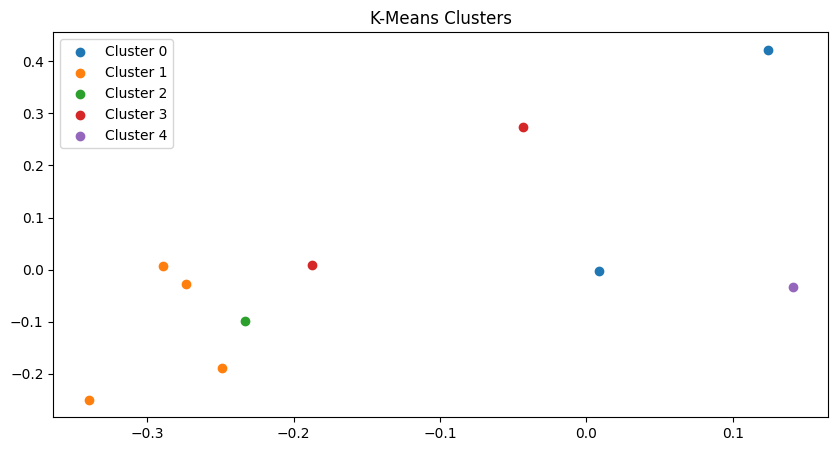

In [ ]:
def visualize_clusters(embeddings, labels, title):
    plt.figure(figsize=(10, 5))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        idx = labels == label
        plt.scatter(embeddings[idx, 0], embeddings[idx, 1], label=f'Cluster {label}')
    plt.title(title)
    plt.legend()
    plt.show()

visualize_clusters(sentence_embeddings, cluster_labels, 'K-Means Clusters')

In [ ]:
def print_clusters(texts, labels, title):
    clusters = {}
    for i, label in enumerate(labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(texts[i])

    print(f"\n{title} Clusters:")
    for label, sentences in clusters.items():
        print(f"Cluster {label}:")
        for sentence in sentences:
            print(f"  {sentence}")

print_clusters(texts, cluster_labels, 'K-Means')


K-Means Clusters:
Cluster 1:
  Looking for a software engineer proficient in Python and JavaScript to work on full-stack development with experience in Django and React.
  Looking for a machine learning engineer experienced in building models using TensorFlow and PyTorch to work on predictive analytics projects.
  Seeking a UX/UI designer to create engaging, user-friendly interfaces, with strong skills in Figma and Adobe XD.
  Hiring a data scientist with experience in statistical modeling, data mining, and visualization tools like Tableau and Power BI.
Cluster 3:
  Seeking a marketing specialist with expertise in SEO, content strategy, and social media management to develop and execute digital marketing campaigns.
  Seeking an HR manager to handle employee relations, talent acquisition, and performance management for a fast-growing tech startup.
Cluster 2:
  Hiring a financial analyst to perform data-driven analysis, generate financial reports, and assist in strategic decision-making

In [ ]:
valid_labels = cluster_labels != -1
if np.sum(valid_labels) > 1:  # Check if there are more than one valid sample
    silhouette_avg = silhouette_score(sentence_embeddings[valid_labels], cluster_labels[valid_labels])
    print(f"Silhouette Score: {silhouette_avg:.3f}")
else:
    print("Silhouette Score: Not applicable (less than 2 valid samples)")

Silhouette Score: 0.127
